In [ ]:
%%capture
import umap
import pandas as pd
import numpy as np
# import yfinance as yf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from joblib import Parallel, delayed
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from mpl_toolkits.axes_grid1 import make_axes_locatable


%config InlineBackend.figure_format = 'retina'
sns.set_theme('notebook', 'white', font_scale=1.2, palette='tab10')

In [30]:
import os
paths = glob('individual_book_train/*.csv')

# 2) Build your DataFrame
df_files = pd.DataFrame({'book_path': paths})

# 3) Extract stock_id from the base filename, not the full path
df_files['stock_id'] = (
    df_files['book_path']
      .map(os.path.basename)       # e.g. "42.csv"
      .str.replace(r'\.csv$', '', regex=True).str.extract(r'(\d+)')    # -> "42"
      .astype(int)
)

# 4) (Optional) sort by stock_id
df_files = df_files.sort_values('stock_id').reset_index(drop=True)
    
df_target_train = pd.read_csv('./Optiver_additional data/train.csv')
df_volatility_train = df_target_train.groupby('time_id').target.mean()

df_files.head()
# df_target_train.head()
# df_volatility_train.head()

,book_path,stock_id
0,individual_book_train/stock_0.csv,0
1,individual_book_train/stock_1.csv,1
2,individual_book_train/stock_2.csv,2
3,individual_book_train/stock_3.csv,3
4,individual_book_train/stock_4.csv,4


In [ ]:
def rmspe(y_true, y_pred):
    return ((((y_true - y_pred) / y_true)) ** 2).mean() ** 0.5

def plot_price(stock_id, time_id, price_name, kind, ax):
    r = df_files.query(f'stock_id == {stock_id}').iloc[0]
    df = pd.read_csv(r.book_path, usecols=['time_id', 'seconds_in_bucket', price_name])
    df = df.query(f'time_id == {time_id}').drop(columns='time_id').set_index('seconds_in_bucket').reindex(np.arange(600), method='ffill')
    min_diff = np.nanmin(abs(df[price_name].diff().where(lambda x: x > 0)))
    if kind == 'price_norm':
        df[price_name].plot.line(legend=False, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} normalized')
    elif kind == 'price_change':
        df = df[price_name].diff().reset_index()
        df.plot.bar(x='seconds_in_bucket', y=price_name, color=np.where(df[price_name] > 0, 'g', 'r'), legend=False, edgecolor='none', width=1, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} change')
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(min_diff))
    elif kind == 'ticks_change':
        df = df[price_name].diff().div(min_diff).reset_index()
        df.plot.bar(x='seconds_in_bucket', y=price_name, color=np.where(df[price_name] > 0, 'g', 'r'), legend=False, edgecolor='none', width=1, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} change (ticks)')
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    elif kind == 'price_original':
        df[price_name] = 0.01 / min_diff * df[price_name]
        df[price_name].plot.line(legend=False, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} original')

    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(30))
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--')
    ax.set_xlim(0, 600)
    
def plot_emb(emb, color, name, kind='volatility', fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    if kind == 'volatility':
        norm = mpl.colors.LogNorm()
        ticks = mpl.ticker.LogLocator(2),
        formatter = mpl.ticker.ScalarFormatter()
    elif kind == 'date':
        norm = None
        ticks = None
        formatter = mpl.dates.AutoDateFormatter(mpl.dates.MonthLocator())
    plot = ax.scatter(emb[:, 0], emb[:, 1], s=3, c=color, edgecolors='none', cmap='jet', norm=norm);
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)    
    cb = fig.colorbar(plot, label=kind, format=formatter,
                      ticks=ticks, cax=cax)
    cb.ax.minorticks_off()
    ax.set_title(f'{name}')

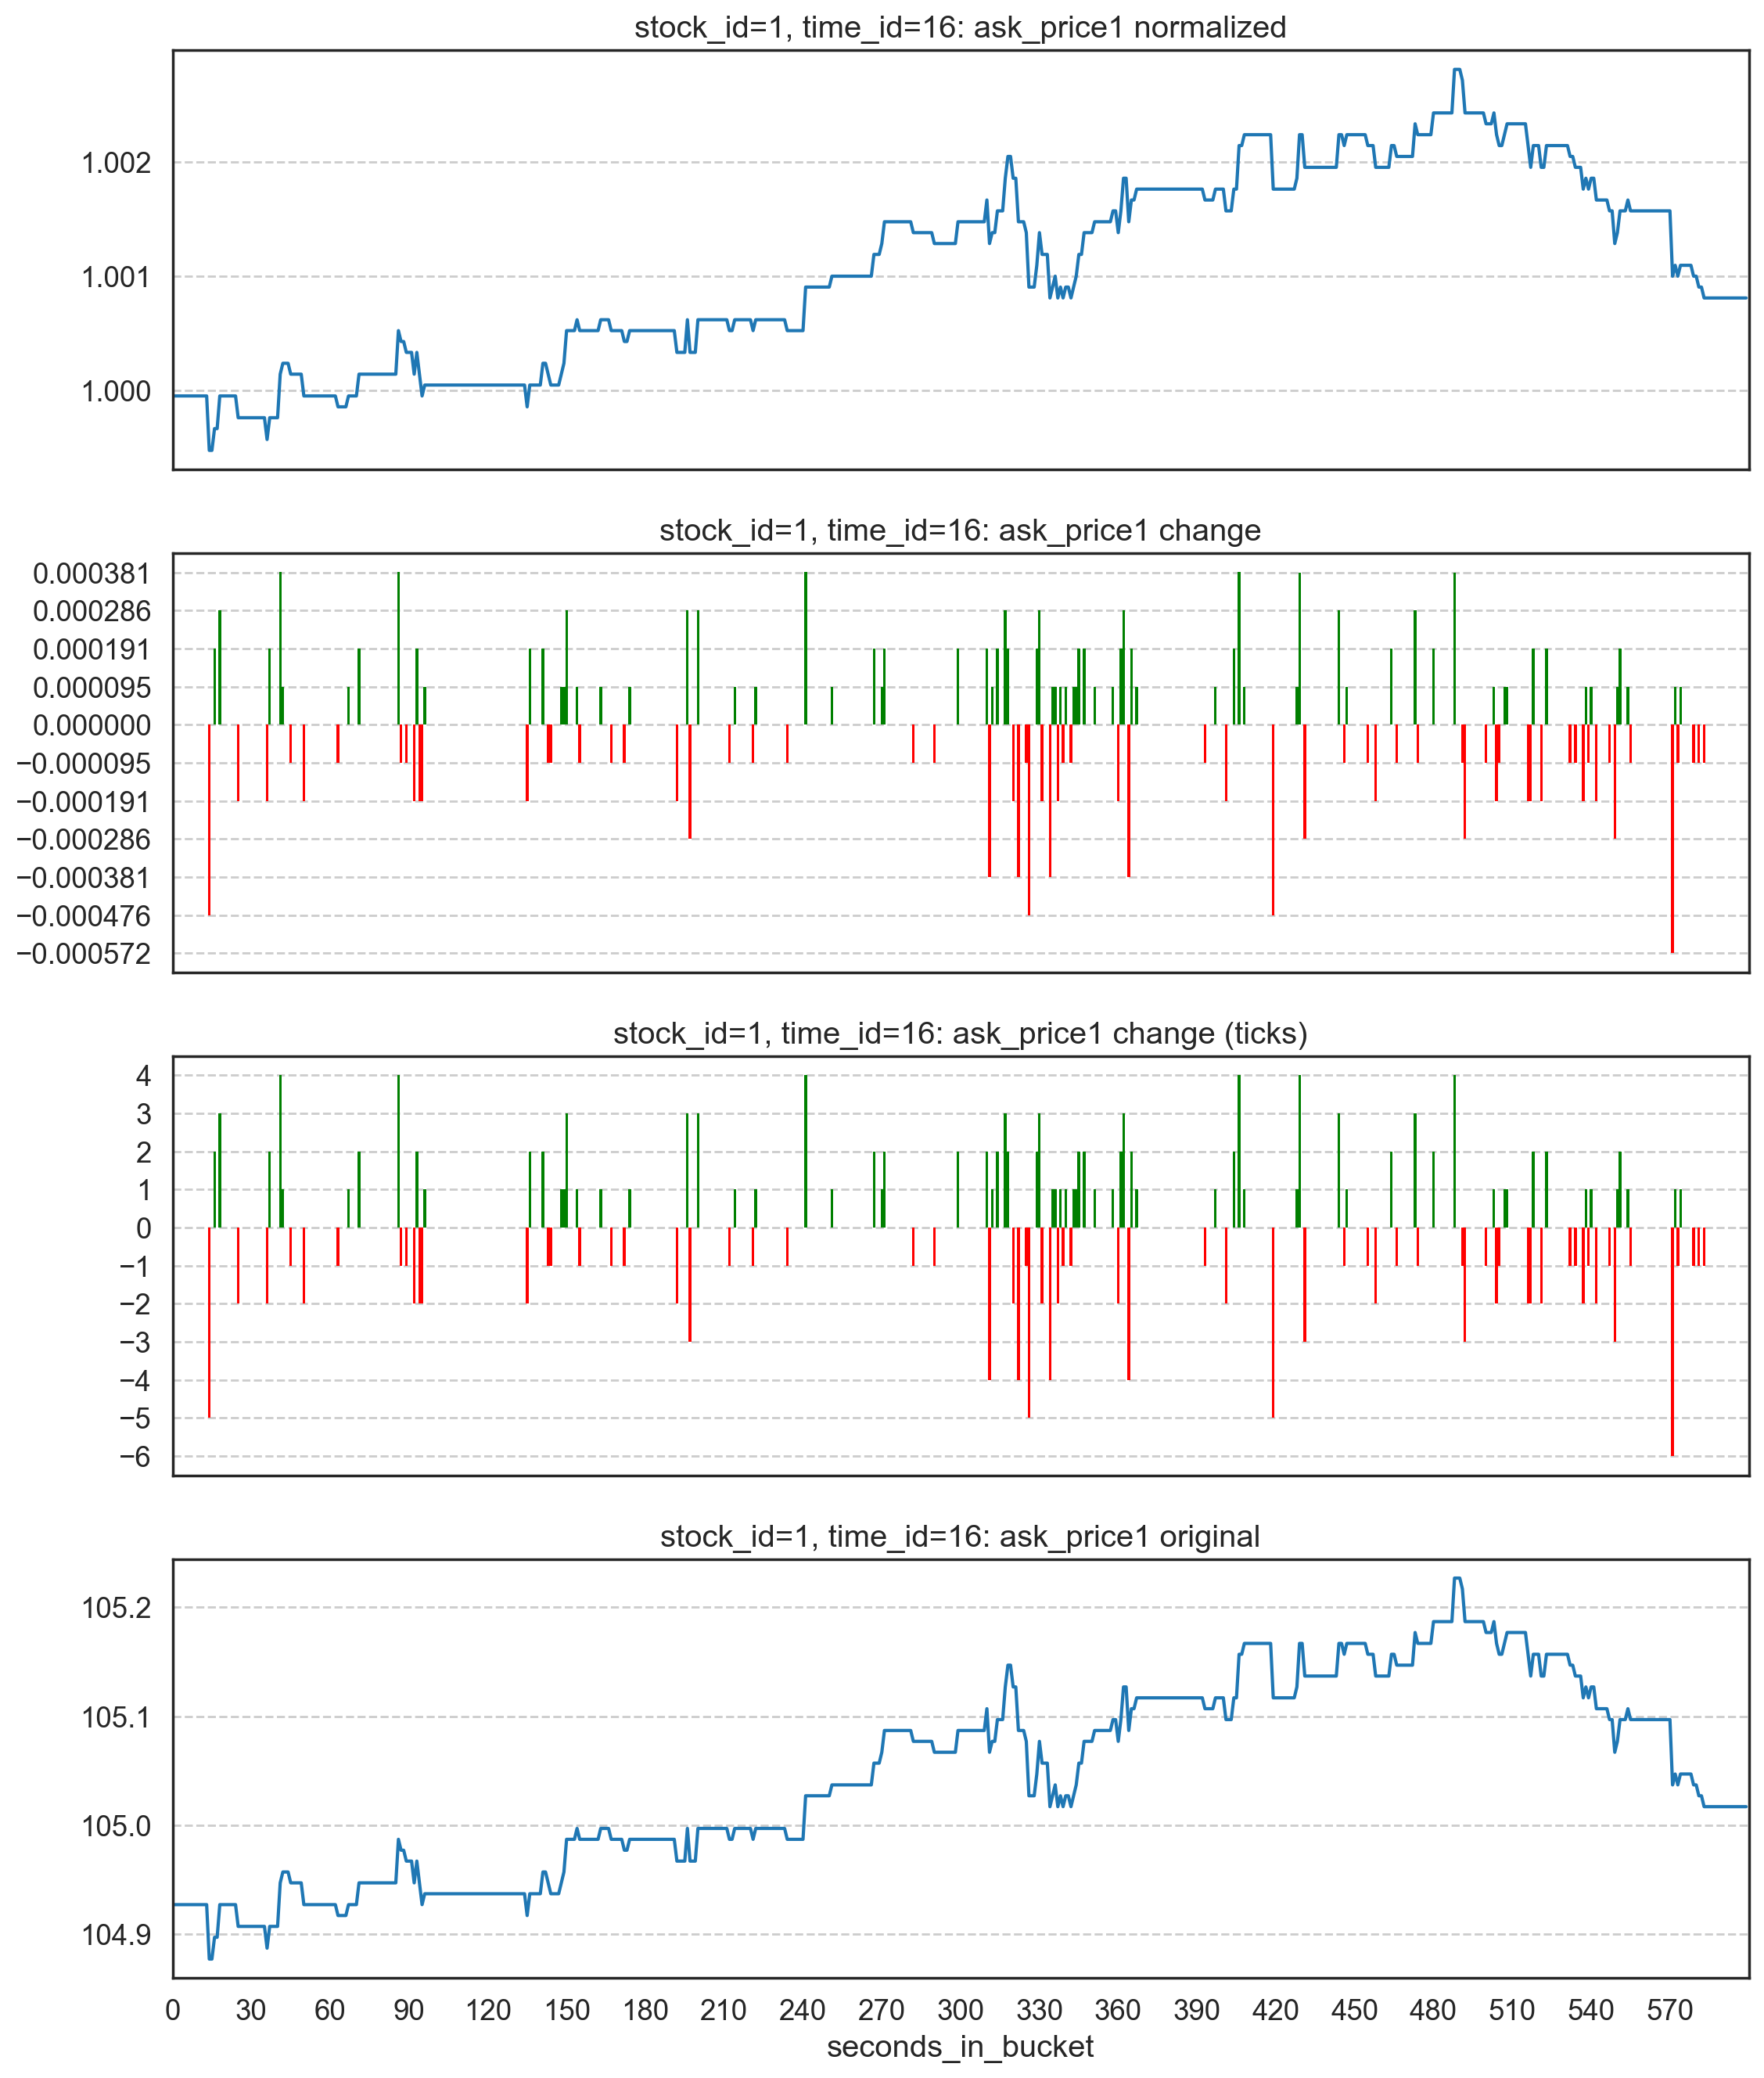

In [29]:
f, ax = plt.subplots(4, 1, sharex=True, figsize=(13, 16))        
plot_price(1, 16, 'ask_price1', 'price_norm', ax[0])
plot_price(1, 16, 'ask_price1', 'price_change', ax[1])
plot_price(1, 16, 'ask_price1', 'ticks_change', ax[2])
plot_price(1, 16, 'ask_price1', 'price_original', ax[3])

In [ ]:
# ── Chunk 1: Recover time_id ordering ─────────────────────────────

import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold     import SpectralEmbedding

# 2) Denormalize: for each stock_id/time_id, infer the normalized tick size
def denorm_scale(grp, price_col='ask_price1'):
    # forward-fill seconds 0–599
    grp = grp.set_index('seconds_in_bucket') \
             .reindex(range(600), method='ffill') \
             .reset_index()
    diffs = grp[price_col].diff().abs()
    tick = diffs[diffs>0].min()                # normalized tick
    return (grp[price_col] * (0.01/tick)).mean()

# build a DataFrame time_id × stock_id of denorm prices
denorm_list = []
for _, row in df_files.iterrows():
    # print(row.iloc[0])
    df = pd.read_csv(row.iloc[0], usecols=['time_id','seconds_in_bucket','ask_price1'])
    s = df.groupby('time_id').apply(denorm_scale, include_groups=False).rename(row.stock_id)
    denorm_list.append(s)
df_prices_denorm = pd.concat(denorm_list, axis=1)

# 3) Embed the denormalized matrix into 1D and sort
# Handle NaN values by filling them with the column mean
df_prices_denorm_filled = df_prices_denorm.fillna(df_prices_denorm.mean())
scaled = MinMaxScaler().fit_transform(df_prices_denorm_filled)

# Apply SpectralEmbedding
coords = SpectralEmbedding(n_components=1, random_state=0).fit_transform(scaled) #? random_state = 2 
order  = np.argsort(coords[:,0])
time_order = df_prices_denorm.index[order]

# 4) Map each time_id → bucket_idx
time_map = pd.DataFrame({'time_id': time_order})
time_map['bucket_idx'] = time_map.reset_index().index
# Now `time_map` tells you the recovered integer order of every time_id.

The spectral embedding has placed your data points in a coordinate space where proximity reflects temporal closeness. By sorting these coordinates, you've recovered what should be the true time sequence, and bucket_idx simply assigns sequential integer values (0, 1, 2, ...) to each position in this recovered order.

In [40]:
# ── Chunk 2: Build the RV panel ────────────────────────────────

import pandas as pd
import numpy as np

# 1) Compute RV per (stock_id, time_id)
def compute_rv(grp):
    wap = (grp['bid_price1'] * grp['ask_size1'] +
           grp['ask_price1'] * grp['bid_size1']) / (
           grp['bid_size1'] + grp['ask_size1'])
    return np.sqrt((np.log(wap).diff()**2).sum())

rv_records = []
for _, row in df_files.iterrows():
    df = pd.read_csv(row.iloc[0])
    series = df.groupby('time_id').apply(compute_rv, include_groups=False).rename('rv').reset_index()
    series['stock_id'] = row.stock_id
    rv_records.append(series)
rv_df = pd.concat(rv_records, ignore_index=True)

# 2) Merge in the recovered bucket_idx
rv_df = rv_df.merge(time_map, on='time_id')

# 3) Pivot to a wide panel: rows=bucket_idx, cols=stock_id
panel = rv_df.pivot(index='bucket_idx',
                    columns='stock_id',
                    values='rv').sort_index()

# `panel` is now your (T × N) matrix of realised vol,
# aligned in true chronological order.

In [50]:
panel

stock_id,0,1,2,3,4,5,6,7,8,9,...,115,116,118,119,120,122,123,124,125,126
bucket_idx,,,,,,,,,,,,,,,,,,,,,
0,0.004064,0.005316,0.001080,0.006362,0.004470,0.003262,0.007860,0.002082,0.005072,0.003390,...,0.002423,0.004954,0.003948,0.002462,0.002174,0.004036,0.002089,0.002609,0.001246,0.004184
1,0.002170,0.002716,0.001139,0.004660,0.001768,0.003503,0.004873,0.002074,0.005006,0.005012,...,0.001923,0.003071,0.002734,0.001358,0.001482,0.003201,0.001174,0.002067,0.000990,0.005122
2,0.003810,0.003918,0.001582,0.005979,0.003178,0.004337,0.005895,0.002582,0.005693,0.006666,...,0.002473,0.004726,0.003562,0.002195,0.002049,0.004423,0.001562,0.003217,0.001158,0.004494
3,0.003457,0.004531,0.001798,0.005045,0.002486,0.004163,0.003975,0.002045,0.005802,0.005377,...,0.002879,0.003640,0.003831,0.002269,0.002437,0.003622,0.002572,0.003175,0.001705,0.006072
4,0.002795,0.005672,0.001794,0.007567,0.004179,0.003790,0.004569,0.002584,0.005564,0.004519,...,0.002630,0.004560,0.003320,0.002641,0.002205,0.004275,0.001995,0.002461,0.001315,0.002979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.001587,0.001558,0.000904,0.001864,0.002339,0.002163,0.003098,0.001514,0.002006,0.002149,...,0.001216,0.001899,0.002838,0.000911,0.001680,0.001764,0.000898,0.001337,0.000571,0.001886
3826,0.001588,0.001126,0.001315,0.002137,0.003251,0.002483,0.003960,0.001725,0.002379,0.004151,...,0.001002,0.002306,0.002356,0.001646,0.001983,0.001370,0.000733,0.001833,0.000681,0.002243
3827,0.001403,0.001886,0.001333,0.002492,0.002087,0.002763,0.005165,0.000915,0.002736,0.002730,...,0.000768,0.002164,0.002443,0.002044,0.001880,0.001148,0.000869,0.001408,0.000583,0.002642


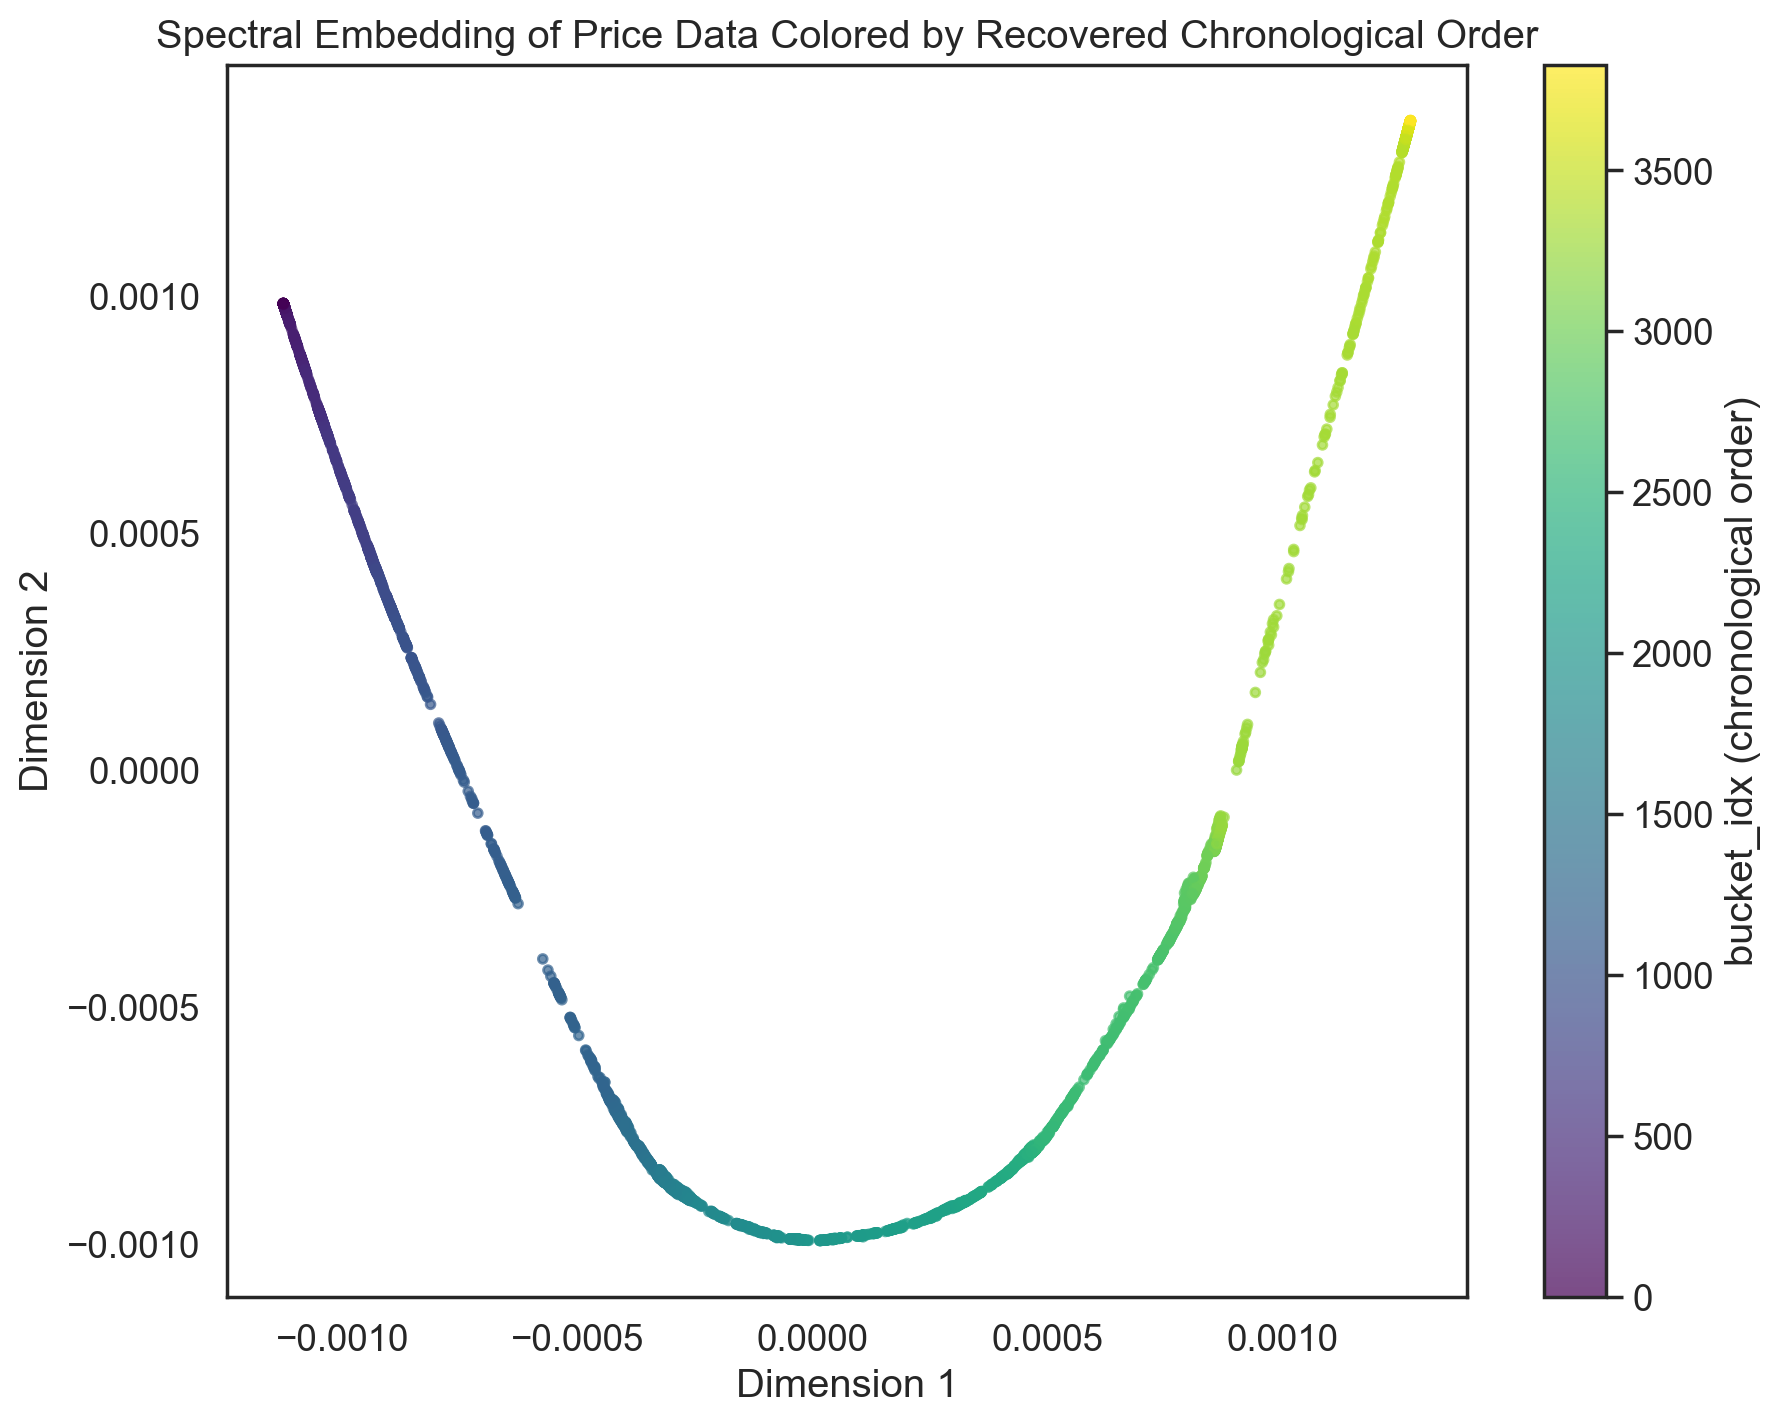

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import SpectralEmbedding
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 1. Visualize the embedding colored by bucket_idx
# This shows if the spectral embedding and your bucket_idx are aligned

# Use the same scaled data you used to create the ordering
df_prices_denorm_filled = df_prices_denorm.fillna(df_prices_denorm.mean())
scaled = MinMaxScaler().fit_transform(df_prices_denorm_filled)

# Create a 2D embedding for visualization
emb = SpectralEmbedding(n_components=2, random_state=0).fit_transform(scaled)

# Create a DataFrame with the embedding coordinates and bucket_idx
df_viz = pd.DataFrame({
    'x': emb[:, 0],
    'y': emb[:, 1],
    'time_id': df_prices_denorm.index,
})

# Merge with your time_map to get bucket_idx
df_viz = df_viz.merge(time_map, on='time_id')

# Plot the embedding colored by bucket_idx
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_viz['x'], df_viz['y'], c=df_viz['bucket_idx'], 
                      cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, label='bucket_idx (chronological order)')
plt.title('Spectral Embedding of Price Data Colored by Recovered Chronological Order')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

!!!!!!! We need to verify that the realised volatility per stocks bucket_idx is indeed correct chronologically when compared with thridparty data soruces!!!!!
!!!!! Remeber, going forward in bucket_idx for a stock is going forward in time!!!!!!